In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# import LAM library for logbook, data analysis...
from pfs.sacFileHandling import Logbook, constructFilelist
import pfs.imageAnalysis as imeas
from pfs.slitFocusAnalysis import *
from pfs.style import colors

In [3]:
from matplotlib import style
style.use('ggplot')

In [4]:
imgPath = '/home/pfs/shared/Pictures/SM1/SLITALIGN'

In [5]:
smId = 2

In [6]:
# filepath of data model
pmodel = '/home/pfs/dev/ait-notebook/optical/input/slit'
file = 'slit-defParam-Ouverture100-fiber65.csv'

In [7]:
zemaxData = pd.read_csv('%s/%s' % (pmodel, file), delimiter=" ")
zemaxMidFit = imeas.fitparabola(x=zemaxData.Slitdefocus, y=zemaxData.MidFiber, deg=15, focus='max')
zemaxEndFit = imeas.fitparabola(x=zemaxData.Slitdefocus, y=zemaxData.ExtremeFiber, deg=15, focus='max')

In [8]:
experiments = pd.read_sql_query('select * from Experiment where type="slitAlignment" order by experimentId desc',
                                con='sqlite:////data/ait/experimentLog-sac.db', index_col='experimentId')

experiments['exptime'] = [Logbook.getParameter(experimentId, 'exptime') for experimentId in experiments.index]
experiments['fiber'] = [Logbook.getParameter(experimentId, 'fiber', doRaise=False) for experimentId in experiments.index]

In [9]:
fiberId = {126:'engtopmid',127:'engbotmid',128:'engtopmid',129:'engtopmid', 130:'engtopmid', 131:'engbotmid', 132:'engbotmid', 133:'engbotmid', 135:'engtopmid'}

experiments['fiber']  = [experiments.fiber[experimentId] if experimentId not in fiberId.keys() else fiberId[experimentId] for experimentId in experiments.index ]

In [10]:
experiments.cmdStr[255]

'spsait slit align exptime=1.0 position=-2,2,10 duplicate=2 fiber=engtopmid'

## Data required : 
To be able to find the right focus, some data acquisition is required.

you need to use ics_spsaitActor to perform your sequence

example : <b>slit throughfocus exptime=6.0 lowBound=-0.5 upBound=1.5 fiber=engbotend nbPosition=10 duplicate=1 </b>

-0.5 : 1.5 is the range of the slit focus


## Input Parameters : 
The only parameters needed is the experimentIds that match your data acquisition sequence

In [11]:
com = True
doBck =True
corrector = False
experimentIds = [126, 127, 128, 129, 130, 131, 132, 133, 135]
experimentIds = [287,288,289,290]
experimentIds = [363,364,365,366]
head = 6
tail = 0
#bck_expId = 260

dfs = []

In [12]:
threshold = 300
radius = 60
doPrint = False
doPlot = False
roi_size = 150

fwhm_radius = radius
fwhm_method = 'gaussian'

0
/data/ait/sac/2020-09-29/SAC011390.fits
1
/data/ait/sac/2020-09-29/SAC011391.fits
2
/data/ait/sac/2020-09-29/SAC011392.fits
3
/data/ait/sac/2020-09-29/SAC011393.fits
4
/data/ait/sac/2020-09-29/SAC011394.fits
5
/data/ait/sac/2020-09-29/SAC011395.fits
6
/data/ait/sac/2020-09-29/SAC011396.fits
7
/data/ait/sac/2020-09-29/SAC011397.fits
8
/data/ait/sac/2020-09-29/SAC011398.fits
9
/data/ait/sac/2020-09-29/SAC011399.fits
10
/data/ait/sac/2020-09-29/SAC011400.fits
11
/data/ait/sac/2020-09-29/SAC011401.fits
12
/data/ait/sac/2020-09-29/SAC011402.fits


/software/conda/lib/python3.6/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


13
/data/ait/sac/2020-09-29/SAC011403.fits
14
/data/ait/sac/2020-09-29/SAC011404.fits
15
/data/ait/sac/2020-09-29/SAC011405.fits
16
/data/ait/sac/2020-09-29/SAC011406.fits
17
/data/ait/sac/2020-09-29/SAC011407.fits
18
/data/ait/sac/2020-09-29/SAC011408.fits
19
/data/ait/sac/2020-09-29/SAC011409.fits
20
/data/ait/sac/2020-09-29/SAC011410.fits
21
/data/ait/sac/2020-09-29/SAC011411.fits
22
/data/ait/sac/2020-09-29/SAC011412.fits
23
/data/ait/sac/2020-09-29/SAC011413.fits
24
/data/ait/sac/2020-09-29/SAC011414.fits
25
/data/ait/sac/2020-09-29/SAC011415.fits
26
/data/ait/sac/2020-09-29/SAC011416.fits
27
/data/ait/sac/2020-09-29/SAC011417.fits
28
/data/ait/sac/2020-09-29/SAC011418.fits
29
/data/ait/sac/2020-09-29/SAC011419.fits
30
/data/ait/sac/2020-09-29/SAC011420.fits
31
/data/ait/sac/2020-09-29/SAC011421.fits
32
/data/ait/sac/2020-09-29/SAC011422.fits
33
/data/ait/sac/2020-09-29/SAC011423.fits
34
/data/ait/sac/2020-09-29/SAC011424.fits
35
/data/ait/sac/2020-09-29/SAC011425.fits
36
/data/ai

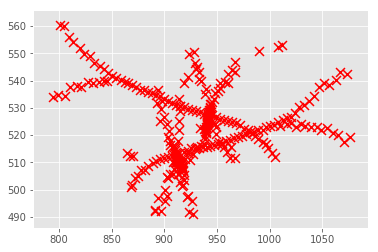

In [13]:
for experimentId in experimentIds:
    visitStart, visitEnd = Logbook.visitRange(experimentId=experimentId)
    filelist = constructFilelist(visitStart=visitStart, visitEnd=visitEnd)
    duplicate = int(Logbook.getParameter(experimentId=experimentId, param='duplicate'))
    filelist = filelist[head*duplicate:len(filelist)-tail*duplicate]
    guessedPos = getSlitPosFromMove(experimentId)

    res = []
    for i in range(len(filelist) // duplicate):
        print(i)
        print(filelist[i])
        hdr, data = stackedImage(filelist=filelist, ind=i, duplicate=duplicate, doBck=doBck)
    #    peak = getPeakData(data, com=com, doBck=False, doPlot=doPlot, doPrint=doPrint)
        if doPlot:
            plt.imshow(data, origin = 'lower', cmap = 'gray', vmin=300, vmax=800)
        calc = iqcalc.IQCalc(None)
        peaks = calc.find_bright_peaks(data, threshold=threshold, radius=radius)
        objlist = calc.evaluate_peaks(peaks, data, fwhm_radius=radius, cb_fn=None, ev_intr=None, fwhm_method='gaussian')
        if doPrint: 
            print(len(objlist))


        objlist = [elem for elem in objlist if elem['fwhm'] > 15]
        objlist = [elem for elem in objlist if (elem['fwhm_x'] > 15) and (elem['fwhm_y'] > 15)]
        objlist = [elem for elem in objlist if threshold < elem['brightness'] < 50000]
        for obj in objlist :
            plt.scatter(obj['oid_x'],obj['oid_y'],s=80,c='red',marker='x',label='peak', edgecolors=None)
        if doPlot:
            plt.show()

        if doPrint: 
            print(f"Object detected after filtering: {len(objlist)}")
        if not objlist:
            print('peak has not been properly detected')
            obj ={"px": np.nan,
                  "py": np.nan,
                  "oid_x": np.nan,
                  "oid_y": np.nan,
                  "ee20" : np.nan
                 }
            dict(obj)
        else:
            maxi = np.argmax([imeas.getEE(image=data, cx=peak['oid_x'], cy=peak['oid_y'], ee_size=20, roi_size=300) for peak in objlist])
            cx = objlist[maxi]['oid_x']
            cy = objlist[maxi]['oid_y']

        peak = imeas.getPeakData(data, cx, cy, EE=[20], roi_size=roi_size, doPlot=False, com=com, fwhm_radius=fwhm_radius, fwhm_method=fwhm_method)
        peak['experimentId'] = experimentId
        try:
            fca_x = hdr['FCA_X']
        except KeyError:
            fca_x = guessedPos[i]

        peak['fca_x'] = fca_x
        res.append(peak)
        if doPlot:
            plt.show()
        if doPrint:
            print("\n")
        df = pd.DataFrame(res)
    dfs.append(df)

cube = pd.concat(dfs)

   

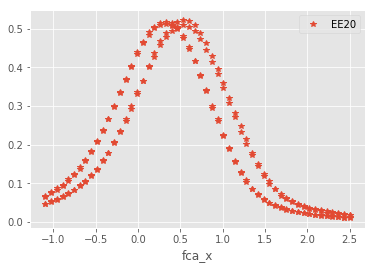

In [14]:
cube.plot(x='fca_x',y='EE20',style='*')

experimentId
363    AxesSubplot(0.125,0.125;0.775x0.755)
364    AxesSubplot(0.125,0.125;0.775x0.755)
365    AxesSubplot(0.125,0.125;0.775x0.755)
366    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

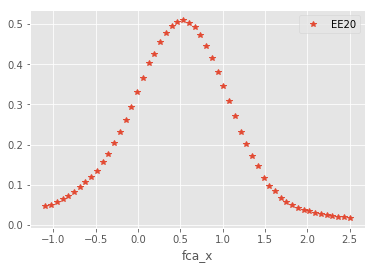

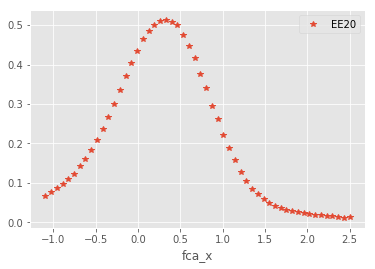

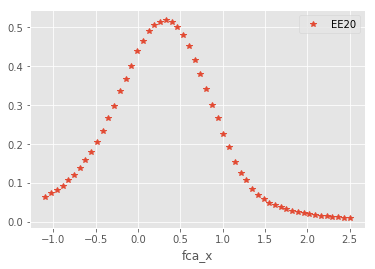

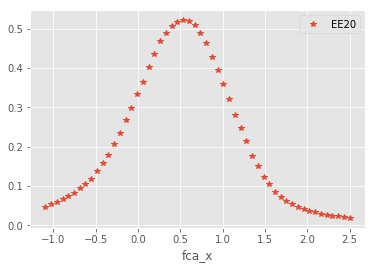

In [15]:
cube.groupby(["experimentId"]).plot(x='fca_x',y='EE20',style='*')

In [16]:
thres_neighbor = -0.1
doNeighborFilter = True

In [17]:

if doNeighborFilter :
    tot = []
    for  group_name, series in cube.groupby(["experimentId"]):
        series["EE20_diff"] = series.EE20 - (series.EE20.shift(-1) + series.EE20.shift(1))/2 

        series["EE20_diff"].fillna(0, inplace=True)
        series["EE20_diff_flag"] = (series.EE20_diff> thres_neighbor)
        tot.append(series)
        cube2 = pd.concat(tot)


/software/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/software/conda/lib/python3.6/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/software/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus

experimentId
363    AxesSubplot(0.125,0.125;0.775x0.755)
364    AxesSubplot(0.125,0.125;0.775x0.755)
365    AxesSubplot(0.125,0.125;0.775x0.755)
366    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

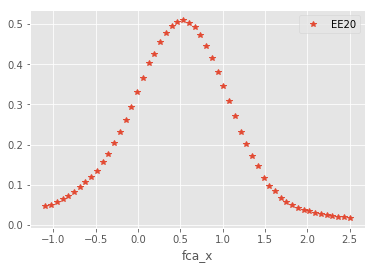

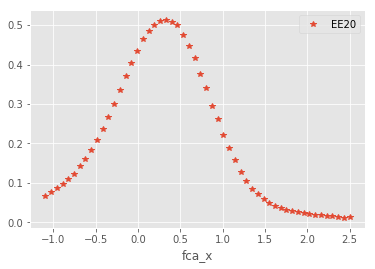

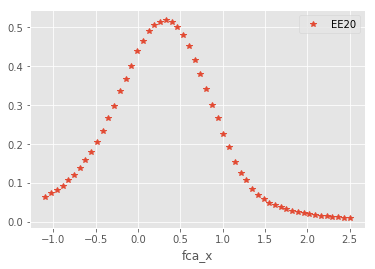

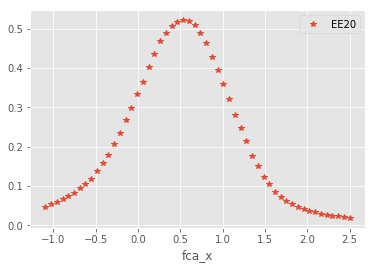

In [18]:
cube2[cube2.EE20_diff_flag].groupby(["experimentId"]).plot(x='fca_x',y='EE20',style='*')

In [19]:
def fitFocusData(cube, corrector=False, doPlot=False, index='fca_x'):
    thfoc_data = []
    
    for experimentId, series in cube.groupby('experimentId'):
        series = series.dropna()
        thfoc = getFocus(series, 'EE20', index, corrector=corrector)
#        for criteria in ['brightness', 'fwhm']:
#            thfoc[criteria] = getFocus(series, criteria, index, corrector=corrector)[criteria]

        thfoc['px'] = np.interp(thfoc[index], series[index], series['px'])
        thfoc['py'] = np.interp(thfoc[index], series[index], series['py'])
        thfoc['experimentId'] = experimentId
        thfoc_data.append(thfoc)
        
    thfoc_data = pd.concat(thfoc_data)

    if doPlot:
        kwargs = dict(grid=True, figsize=(14,10), legend=True, subplots=True)
#        criterias = ['EE20', 'brightness', 'fwhm']
        criterias = ['EE20']
        
        for experimentId, fit in thfoc_data.groupby('experimentId'):
            raw = cube.query("experimentId==%d"%(experimentId))
            axes = fit.set_index(index)[criterias].plot(**kwargs)
            for i, criteria in enumerate(criterias):
                axes[i].plot(raw[index].as_matrix(), raw[criteria].as_matrix(), 'o')
                
    return thfoc_data

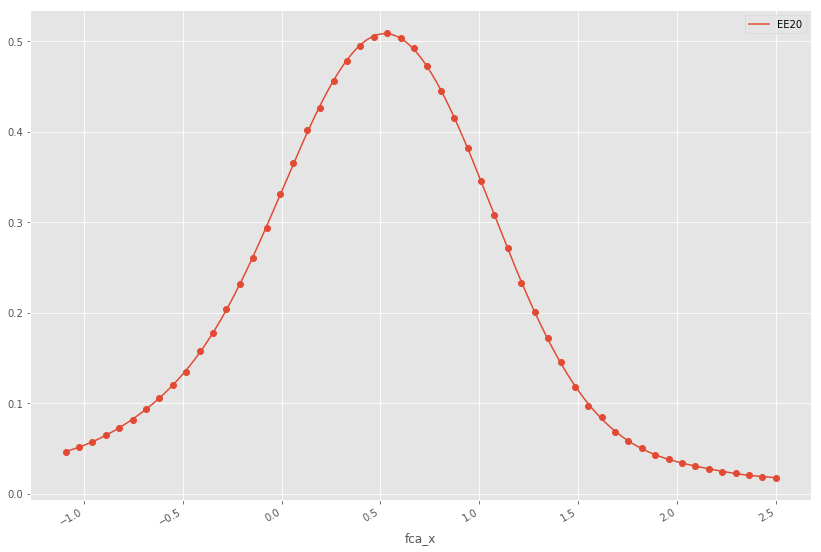

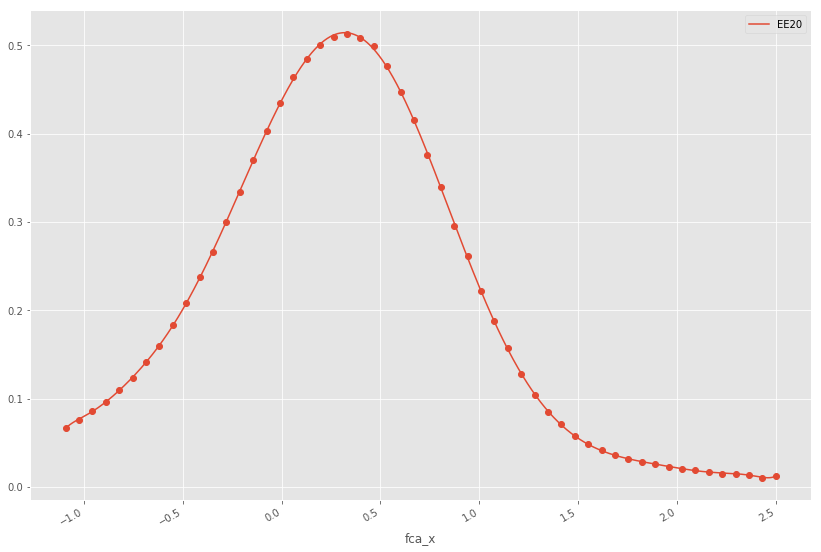

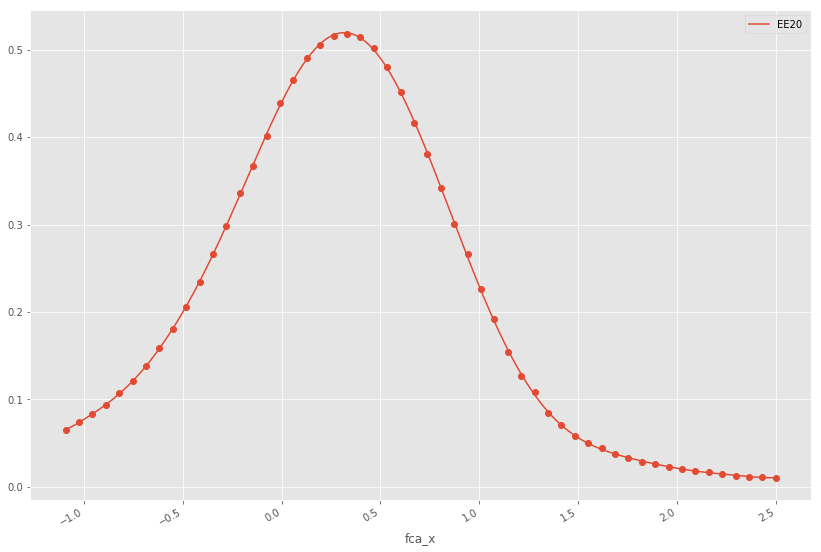

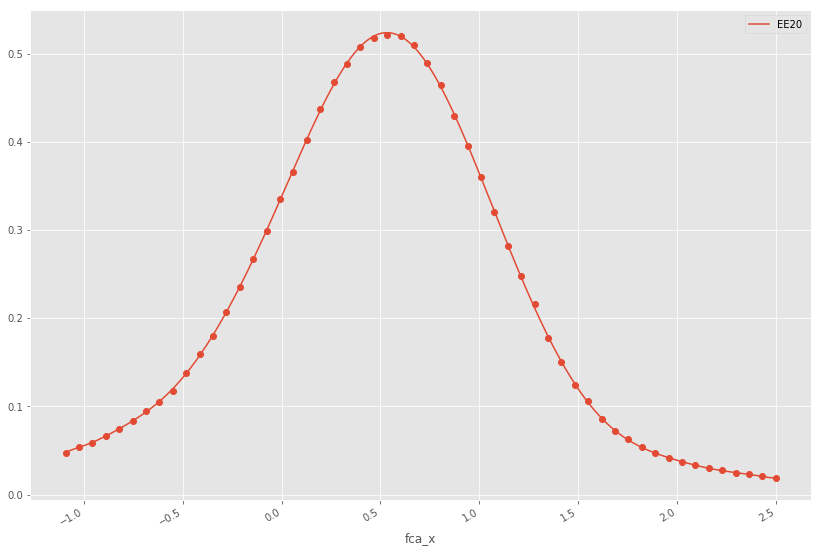

In [20]:
thfocModel= fitFocusData(cube2[cube2.EE20_diff_flag], corrector=False, doPlot=True)

In [21]:
def getFocusModel(fitdata, index='fca_x'):
    data = []
    for experimentId, series in fitdata.groupby('experimentId'):
        series = series.dropna()
#        for criteria in ['EE20', 'brightness', 'fwhm']:
        for criteria in ['EE20']:

            ixmax = series[criteria].idxmax() if criteria !='fwhm' else series[criteria].idxmin()
            focus = series[index][ixmax]
            px = series.px[ixmax]
            py = series.py[ixmax]
            mat = [experimentId, criteria, px, py, focus]
            data.append(tuple(mat))
    
    return pd.DataFrame(data, columns=['experimentId', 'criteria', 'px', 'py', index])

In [22]:
focusModel = getFocusModel(thfocModel)

In [23]:
vline = True
plotModel = True
criteria = 'EE20'
index = 'fca_x'

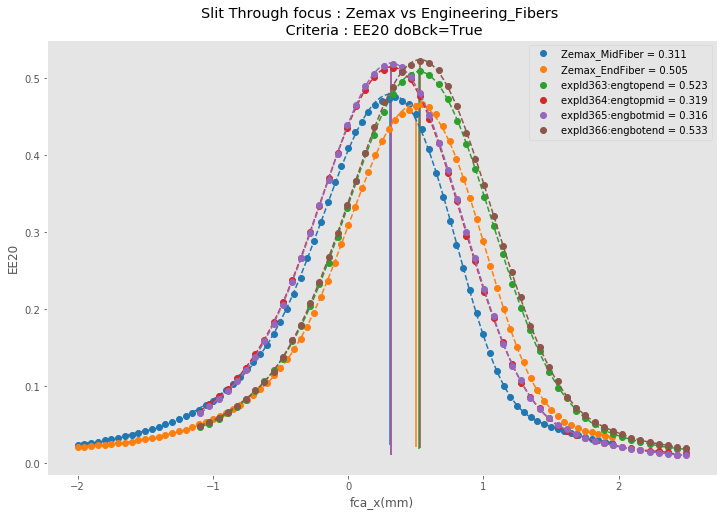

In [24]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111)
j=2

if plotModel:
    ax1.plot(zemaxData.Slitdefocus, zemaxData.MidFiber, 'o', color=colors[0], label='Zemax_MidFiber = %.3f' % zemaxMidFit.focus)
    ax1.plot(zemaxMidFit.x, zemaxMidFit.y, '--', color=colors[0])
    if vline:
        ax1.vlines(color=colors[0], **zemaxMidFit.vline)

    ax1.plot(zemaxData.Slitdefocus, zemaxData.ExtremeFiber, 'o', color=colors[1], label='Zemax_EndFiber = %.3f' % zemaxEndFit.focus)
    ax1.plot(zemaxEndFit.x, zemaxEndFit.y, '--', color=colors[1])
    if vline:
        ax1.vlines(color=colors[1], **zemaxEndFit.vline)

for experimentId, df in cube.groupby('experimentId'):
    fit = thfocModel.query("experimentId==%d"%(experimentId))
    focus = focusModel.query("experimentId==%d and criteria=='%s'"%(experimentId, criteria))
    
    ax1.plot(df[index], df[criteria], 'o', color=colors[j], 
             label='expId%d:%s = %.3f' % (experimentId, experiments.fiber[experimentId], focus[index]))
    ax1.plot(fit[index], fit[criteria], '--', color=colors[j])
    
    if vline:
        ax1.vlines(x=focus[index], ymin=fit[criteria].min(), ymax = fit[criteria].max(), color=colors[j])
    j+=1

    
lns = [line for i, line in enumerate(ax1.get_lines()) if not i % 2]
labs = [line.get_label() for line in lns]

ax1.legend(lns, labs)
ax1.set_xlabel('%s(mm)'%index)
ax1.set_ylabel(criteria)

plt.title('Slit Through focus : Zemax vs Engineering_Fibers \n Criteria : %s doBck=True' %criteria)
plt.grid()

In [29]:
distance_fibres = 138.84
delta_focus = (0.533 - 0.523)
angle=np.arctan(delta_focus/distance_fibres)
angle_degre=(angle*180)/(np.pi)
print(angle_degre)


0.004126748733362541


In [26]:
((0.648+0.658)/2) - 0.309


0.34400000000000003

In [27]:
0.270-0.0062

0.26380000000000003

In [28]:
1.532-0.885

0.647